<a href="https://colab.research.google.com/github/ItamarBerger/TabularDS-part1/blob/main/DS_tabular_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Overview of a regression assignment with the "Avocado" dataset
Attempting to fit Average Price of Avocado (each row is a specific date).


### 0. Imports

In [ ]:
!git clone https://github.com/ItamarBerger/TabularDS-part1

In [ ]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")


### 1. Introducing the Avocdeo-prices dataset -- Exploratory Data Analysis (EDA)
##### The goal of this phase is to understand the different features and relations between them and w.r.t. the target feature

Loading the CSV dataset

In [ ]:
dtf = pd.read_csv('/content/TabularDS-part1/data/avocado.csv')



In [ ]:
dtf.columns = dtf.columns.str.replace(' ', '')


In [ ]:
dtf.head()

In [ ]:

dtf.describe()


#### Examining the target feature - "AveragePrice": Using a histogram
Our main goal at this point is to examine the highest correlations (in absolute value - also taking into account strong negative correlations) between a feature and the target col (Life Expectancy).

In [ ]:
min_val_corr = 0.0

df_numeric = dtf.drop(columns=dtf.select_dtypes(include=['object']).columns).drop('Date', axis=1, errors= 'ignore')
target = 'AveragePrice'
# skip index column
corr_matrix = df_numeric.iloc[:, 1:].corr()
# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Plot heatmap
sns.heatmap(corr_matrix)     # Colorbar size
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()



The histogram above well demonstrate that the features 'TotalVolume' and '4046', '4225', '4770' (which are different price codes for different avocados -(reference) https://loveonetoday.com/how-to/identify-hass-avocados/)
have **high positive correlation**.
On the other hand 'TotalVolume' has pretty strong negative correlation to the target feature  (AveragePrice).

In [ ]:
df_numeric[['AveragePrice', 'year']].hist(figsize=(10, 8), bins=50, xlabelsize=12, ylabelsize=8)
plt.show()

##The visualization above demonstrate the following key point:
1. It seems like the avgPrice is distributed as a **normal-like distribution**- it may become usefull in the prediction part.



### Now we'd like to take a deeper loook into the AveragePrice of avocados with respect toits type (organic/conventional).

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
status_counts = dtf['type'].value_counts()
axes[0].pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#0fffc7','#6693ff','#99ff99'])
sns.boxplot(x='type', y='AveragePrice', data=dtf.dropna(), ax = axes[1])
axes[1].set_title('Boxplot of AveragePrice by type')
dtf =  dtf.dropna()

plt.tight_layout()

# Show the plot
plt.show()


So we can already notice that both avocado types appear in the dataset **roughly equally**.

 An interesting fact here, we see a **significant difference** in the averagePrice of organic avocados as opposed to conventional.
  
Moreover, it seems like there are lots of outliers samples here. especially for organic avocados and high-price conventional.

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(25, 5))

dtf.groupby(pd.cut(dtf['TotalVolume'],5))['AveragePrice'].mean().plot(kind='line',ax=axes[0])
# Show the plot
axes[0].set_title("AveragePrice with respect to Total Volume")
axes[1].set_title("AveragePrice over the years")
sns.regplot(data=dtf,x='year',y='AveragePrice')
plt.tight_layout()
# Show the plot
plt.show()

Over here, we wanted to further explore the possible relationship between the averagePrice and the year of the sample and the TotalVolume of avocatos seold at this date. What can we tell based of the visualizations above?
1. The avgPrice **increased** over the years
2. In 2016 and 2017 we had signicantlly more samples
3. The averagePrice is decreasing with respect to the TotalVolume -> may imply an interesting market trend (less sells means a higher price, while more sells can lead to a lower peice)

In [ ]:
grouped = dtf.groupby("year")[["4046", "4225", "4770"]].sum()
for i, (year, totals) in enumerate(grouped.iterrows()):
    plt.figure(figsize=(7, 4))
    plt.pie(totals, labels=totals.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Types Distribution in {year}')
    plt.show()

So we already looked into the relationship between avgPrice and the year/totalVolume. We now want to take a deeper look into what actually might change between the year. That could lead us to the cause  of the avgPrice going up as the years go by (at least so they do in our given datases).
One way of exploring this lead, would be to take a look into what is the propotional mix of avocados types which were sold during each year. The above pie charts demonstrate some interesting facts:

1. something surprising happens in 2017- prpotional part of 4046 sold, is **up by almost 10%** comparing to previous years.
2. It semms like 4770 type "took a dive" in 2017.


Maybe in the future, we could use this trend to explain other trends as well. such as the increse of price over the years as a result of the differenr prpotional mix between the avocado types sold over the years and so on.


While the plot above is difficult to read, we can bin the year column then group by and view the mean price

### 2 - Cleaning and Preprocessing

A. Split to Train and Test, then see the target feature distributions:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
dtf['type'] = dtf['type'].map({'organic': 1, 'conventional': 0})
dtf = dtf.drop(columns=['Date'])
le = LabelEncoder()

# Apply label encoding to the 'region' column
dtf['region'] = le.fit_transform(dtf['region'])

In [ ]:
dtf_train, dtf_test = train_test_split(dtf,
                      test_size=0.25)

Concat the one-hot attributes and drop the original

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# convert categorical feature into one-hot encoding representation
#dummy_train = pd.get_dummies(dtf_train['type'], prefix='type')
#dummy_test = pd.get_dummies(dtf_test['type'], prefix='type')
# update test and train datasets with the new column of 'Status' Feature
#dtf_train = pd.concat([dtf_train, dummy_train], axis=1).drop(columns='type')
#dtf_test = pd.concat([dtf_test, dummy_test], axis=1).drop(columns='type')


### 3. Create a Baseline Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#separate X from y
X_train = dtf_train.drop('AveragePrice',axis=1)
X_test = dtf_test.drop('AveragePrice',axis=1)


y_train = dtf_train['AveragePrice']
y_test = dtf_test['AveragePrice']




#### Train a linear regression model

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor()

In [ ]:
prediction = model.fit(X_train,y_train).predict(X_test)

### 4. Evaluate how good is the model

Many metrics exist for evaluating the regression over the test data.


In [ ]:
from sklearn.metrics import r2_score,mean_squared_error ,mean_absolute_error

Let's start with r^2: R Squared is the squared sum of differences from the actual values and the predicted values, divided by the squared differences from the mean (i.e var*n)

In [ ]:
r2_score(y_test, prediction)

<br> So we already have a pretty good r2 score.
<br>
Let's see more metrics:

In [ ]:
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.3f}".format(mean_absolute_error(y_test, prediction)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.3f}".format(np.sqrt(mean_squared_error(y_test, prediction))))

## residuals
residuals = y_test - prediction
max_error = residuals.abs().max()
max_idx = residuals[residuals==max_error]
#max_true, max_pred = y_test.loc[max_idx], prediction[max_idx]
print("Max Error:", "{:,.3f}".format(max_error))

We now plot the true values against the predicted values.
<br> In the regression line, the predicted values are always on the function y=x

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x = prediction,y = y_test,ax=ax,color='blue')
sns.lineplot(x = prediction,y = prediction,ax=ax,color='black')
plt.title("model's test prediction")
plt.show()

###Let's take a close look at the resuduals:

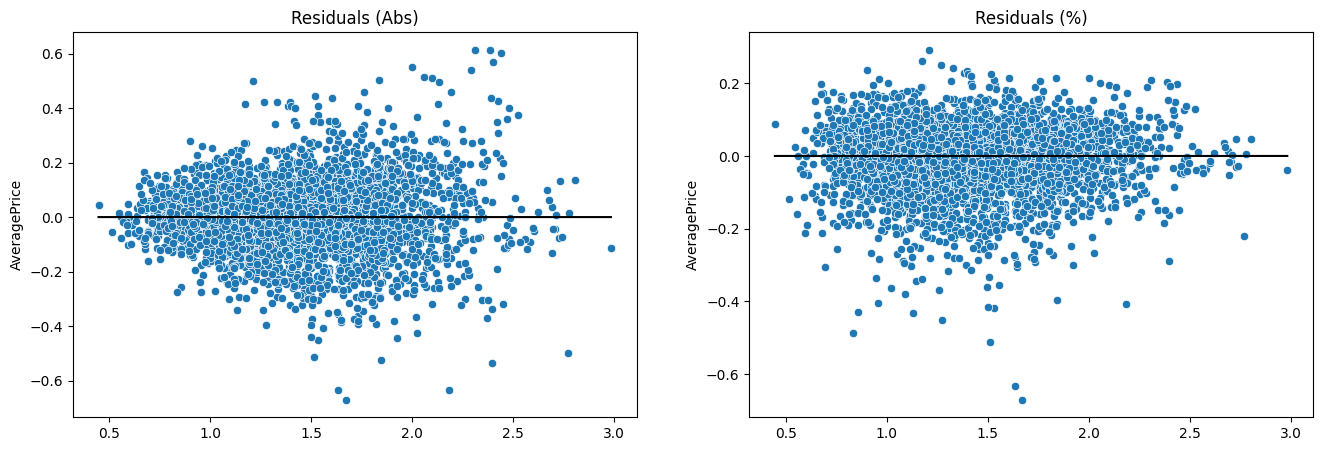

In [29]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.scatterplot(x=prediction,y=residuals,ax=ax[0])
sns.lineplot(x=prediction,y=0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)")
sns.scatterplot(x=prediction,y=residuals/y_test,ax=ax[1])
sns.lineplot(x=prediction,y=0,ax=ax[1],color='black')
ax[1].set_title("Residuals (%)")
plt.show()

Now we can see that the model tends to underestimate f. Specifically  it probably **performs worst** on items with avgPrice of range 0.7-1.8.

#Let's examine explanations for the model's in-accurcacy and specifically its tendency to underestimate#

<Figure size 1000x600 with 0 Axes>

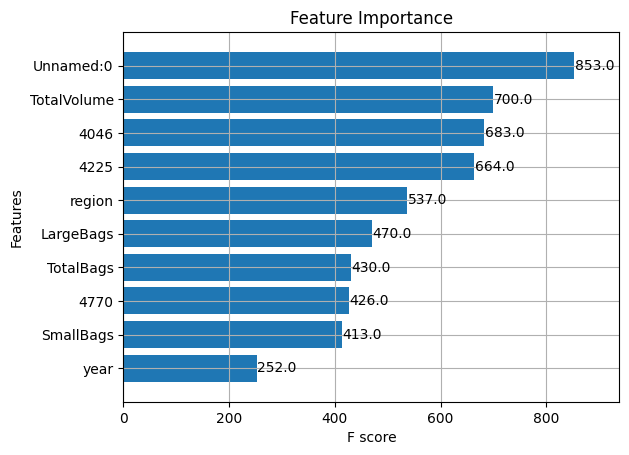

In [30]:
# Plotting feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.title('Feature Importance')
plt.show()

###IMPORTANT NOTE
We see high importance of the "Unnamed" feature which is the date feature. On this part we ignore this feature. Later on, on future assignments, we would pay a closer attention specifically to this feature (non-numeric and non-caterorical feature).

### 4. Model Explainability

We use SHAP to understand the affect of each feature over our model

In [31]:
import shap

In [32]:
shap_sample = X_train.sample(500)

In [ ]:
explainer = shap.Explainer(model.predict, shap_sample)
shap_values = explainer(shap_sample)

In [ ]:
dtf.columns

In [ ]:
shap.plots.beeswarm(shap_values)

Remember that we can also do that to explain the prediction of a single element:

In [ ]:
test_shap_values = explainer(X_test)

What was our biggest relative error?

In [ ]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

Now, we want to explore where does the model performs the **worst**, and why.  
Our initial attempt (inpired by the visualizations of section 2) is to examine the relation between the prediction error and the avocados type (Organic/Conventional).

In [ ]:
X_organic = dtf_test[dtf_test['type'] == 1].drop('AveragePrice',axis=1)
X_conventional = dtf_test[dtf_test['type'] == 0].drop('AveragePrice',axis=1)
y_organic = dtf_test[dtf_test['type'] == 1]['AveragePrice']
y_conventional = dtf_test[dtf_test['type'] == 0]['AveragePrice']



organic_prediction = model.predict(X_organic)
conventional_prediction = model.predict(X_conventional)

residuals_organic = y_organic-organic_prediction
residuals_conventional = y_conventional-conventional_prediction



fig, ax = plt.subplots(2, 2, figsize=(16, 10))
sns.scatterplot(x= organic_prediction,y= residuals_organic,ax=ax[0][0],color = 'darkgreen')
sns.lineplot(x=organic_prediction,y=np.zeros_like(organic_prediction),ax=ax[0][0],color='black')
ax[0][0].set_title("Organic Residuals (Abs)")
sns.scatterplot(x=organic_prediction,y=residuals_organic/y_organic,ax=ax[0][1], color = 'darkgreen')
sns.lineplot(x=organic_prediction,y=np.zeros_like(organic_prediction),ax=ax[0][1],color='black')
ax[0][1].set_title("Organic Residuals (%)")



sns.scatterplot(x= conventional_prediction,y= residuals_conventional,ax=ax[1][0], color='green')
sns.lineplot(x=conventional_prediction,y=np.zeros_like(conventional_prediction),ax=ax[1][0],color='black')
ax[1][0].set_title("Conventional Residuals (Abs)")
sns.scatterplot(x=conventional_prediction,y= residuals_conventional/y_conventional,ax=ax[1][1], color='green')
sns.lineplot(x=conventional_prediction,y=np.zeros_like(conventional_prediction),ax=ax[1][1],color='black')
ax[1][1].set_title("Conventional Residuals (%)")
plt.show()





# What can we actually infer from the comparison above?
1. The model's tendency to underestiate is present **for both** avocado types.
2. It seems that the variance of the residuals for organic avocado is significanly higher than when predicting avgPrice for conventional avocados
3. The model actually **performs worst** for organic avocados. That might be as a result of the **outliers** we visualized on section 2.

Let's look at this problematic point:

In [ ]:
max_id = rel_res[rel_res==rel_res.max()].index[0]
pred_series=pd.Series(prediction,index=rel_res.index)
pred_series[max_id]

max_ordinal_id= X_test.index.get_loc(max_id)
shap.plots.waterfall(test_shap_values[max_ordinal_id])

In [ ]:
len(residuals[residuals > 0.2])

In [ ]:
bad_examples = X_test.loc[residuals[residuals>0.2].index]
bad_examples_shap_values = explainer(bad_examples)
shap.plots.beeswarm(bad_examples_shap_values)

To get even a deeper understanding regarding our model's mistakes, we can compare the distributions of our mistakes to good predictions

In [ ]:
bad_estimates = X_test.loc[residuals[residuals>0.2].index]

In [ ]:
good_estimates = X_test.loc[rel_res[rel_res<0.04].index]

In [ ]:
# plot histograms for good and under estimates
fig, ax = plt.subplots()
good_estimates.year.hist(ax=ax, color='blue', alpha=0.7, label='Good Estimates')
bad_estimates.year.hist(ax=ax, color='red', alpha=0.7, label='Bad Estimates')

# add a legend
ax.legend()

# set x-axis label
ax.set_xlabel("Year", fontsize=12)

# add a title
ax.set_title("Estimates Distribution by Year", fontsize=14)

plt.show()

We can see that our overestimas contains "larger" apartments.
<br> While the model correctly understood that larger apartments are often more expensive, this is not always correct!

In [ ]:
len(good_estimates)

In [ ]:
len(bad_estimates)

##Sources:
aocado's size : https://loveonetoday.com/how-to/identify-hass-avocados/

dataset patterns - https://www.kaggle.com/code/janiobachmann/price-of-avocados-pattern-recognition-analysis

conventional VS organic avocados - https://www.kaggle.com/code/hely333/explore-avocados-from-all-sides
